### Загружаем данные для обучения: `train_texts`, `val_texts`, `test_texts`

In [1]:
from datasets import load_dataset

from sklearn.model_selection import train_test_split

from os.path import isfile

from src.data_utils import clean_text

import pandas as pd

import os


train_texts, val_texts, test_texts = None, None, None
foldername = 'data'
raw_dataset_filepath = os.path.join(foldername, 'raw_dataset.csv')
processed_dataset_filepath = os.path.join(foldername, 'processed_dataset.csv')
train_filepath = os.path.join(foldername, 'train.csv')
val_filepath = os.path.join(foldername, 'val.csv')
test_filepath = os.path.join(foldername, 'test.csv')
text_column = 'text'

# Если такие файлы уже есть, загружаем данные для обучения из них
if isfile(train_filepath) and isfile(val_filepath) and isfile(test_filepath):
    train_texts = pd.read_csv(train_filepath).dropna()[text_column].to_list()
    val_texts = pd.read_csv(val_filepath).dropna()[text_column].to_list()
    test_texts = pd.read_csv(test_filepath).dropna()[text_column].to_list()
# В противном случае скачиваем датасет, обрабатываем, делим его на выборки и сохраняем
else:
    dataset = load_dataset('sentiment140', trust_remote_code=True, split='train', cache_dir='data')['text']
    dataset_df = pd.DataFrame({ text_column: dataset })
    dataset_df.to_csv(raw_dataset_filepath, index=False)

    texts = list(map(clean_text, dataset))
    print(len(texts))
    texts_df = pd.DataFrame({ text_column: texts })
    texts_df.to_csv(processed_dataset_filepath, index=False)

    val_test = 0.2
    test = 0.5
    train_texts, val_test_texts = train_test_split(texts, test_size=val_test, random_state=42)
    val_texts, test_texts = train_test_split(val_test_texts, test_size=test)

    train_df = pd.DataFrame({ text_column: train_texts })
    train_df.to_csv(train_filepath, index=False)

    test_df = pd.DataFrame({ text_column: test_texts })
    test_df.to_csv(test_filepath, index=False)

    val_df = pd.DataFrame({ text_column: val_texts })
    val_df.to_csv(val_filepath, index=False)

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 498/498 [00:00<00:00, 27531.18 examples/s]


1600000


### Из полученных данных формируем датасеты:

In [2]:
from transformers import BertTokenizerFast

from torch.utils.data import DataLoader

from src.next_token_dataset import NextTokenDataset, EvalROUGEDataset, collate_fn, collate_fn_rouge_ds


tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
# Добавим в токенайзер признак конца строки
tokenizer.add_special_tokens({'eos_token': '[EOS]'})
print('EOS token added:', tokenizer.eos_token, tokenizer.eos_token_id)

batch_size = 256

train_dataset = NextTokenDataset(train_texts, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = NextTokenDataset(val_texts, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Датасет для вычисления метрик ROUGE на валидационных данных
val_rouge_dataset = EvalROUGEDataset(val_texts, tokenizer)
val_rouge_dataloader = DataLoader(val_rouge_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

test_dataset = EvalROUGEDataset(test_texts, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

EOS token added: [EOS] 30522


### Обучаем модель:

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


=== Before training ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating ROUGE: 100%|██████████| 515/515 [03:05<00:00,  2.78it/s]


Validation loss: 10.32622881954156
Rouge metrics:
rouge1: 0.0000
rouge2: 0.0000
rougeL: 0.0000
rougeLsum: 0.0000
what are you talking inspector場 browning thinkers 1971 violet catalogue hamilton thus wandpoo ethical tempslusion ष [unused657]



Training epoch 1: 100%|██████████| 4114/4114 [13:14<00:00,  5.18it/s]


Epoch: 1, training loss: 6.5012


Evaluating ROUGE: 100%|██████████| 515/515 [02:20<00:00,  3.66it/s]


Validation loss: 5.718751048115851
Rouge metrics:
rouge1: 0.0010
rouge2: 0.0000
rougeL: 0.0010
rougeLsum: 0.0010
what are you talking ive be just g do all my gym who isnt as f



Training epoch 2: 100%|██████████| 4114/4114 [13:17<00:00,  5.16it/s]


Epoch: 2, training loss: 5.5142


Evaluating ROUGE: 100%|██████████| 515/515 [02:13<00:00,  3.86it/s]


Validation loss: 5.31607094922112
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking what if you been on it and ld me me



Training epoch 3: 100%|██████████| 4114/4114 [13:20<00:00,  5.14it/s]


Epoch: 3, training loss: 5.2735


Evaluating ROUGE: 100%|██████████| 515/515 [02:10<00:00,  3.93it/s]


Validation loss: 5.163194472118489
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking about the fly blog free use march lt3



Training epoch 4: 100%|██████████| 4114/4114 [13:17<00:00,  5.16it/s]


Epoch: 4, training loss: 5.1601


Evaluating ROUGE: 100%|██████████| 515/515 [02:13<00:00,  3.86it/s]


Validation loss: 5.077480015245456
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking about how far i dont have hope you want a vm s much



Training epoch 5: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 5, training loss: 5.0922


Evaluating ROUGE: 100%|██████████| 515/515 [02:14<00:00,  3.83it/s]


Validation loss: 5.023911477987049
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking about you guys are wiing up even though im n ready hold of that class



Training epoch 6: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 6, training loss: 5.0301


Evaluating ROUGE: 100%|██████████| 515/515 [02:15<00:00,  3.79it/s]


Validation loss: 4.9817825419231525
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking about watching you



Training epoch 7: 100%|██████████| 4114/4114 [13:20<00:00,  5.14it/s]


Epoch: 7, training loss: 5.0073


Evaluating ROUGE: 100%|██████████| 515/515 [02:17<00:00,  3.76it/s]


Validation loss: 4.965153240463109
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking about do that had lk rubbing vs manchester there will be a chance



Training epoch 8: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 8, training loss: 4.9900


Evaluating ROUGE: 100%|██████████| 515/515 [02:21<00:00,  3.64it/s]


Validation loss: 4.950162963496829
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking about i promise some more came分 had and click some all date and thats



Training epoch 9: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 9, training loss: 4.9754


Evaluating ROUGE: 100%|██████████| 515/515 [02:14<00:00,  3.82it/s]


Validation loss: 4.93782458629423
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking ibriz makes a lile more an 禾 game pill thx super frustrated



Training epoch 10: 100%|██████████| 4114/4114 [13:19<00:00,  5.14it/s]


Epoch: 10, training loss: 4.9622


Evaluating ROUGE: 100%|██████████| 515/515 [02:12<00:00,  3.88it/s]


Validation loss: 4.927394385476714
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking with jeffmy eyecake will add loucor at the shop n gracies the



Training epoch 11: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 11, training loss: 4.9360


Evaluating ROUGE: 100%|██████████| 515/515 [02:19<00:00,  3.68it/s]


Validation loss: 4.911077143845049
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking about your bld lizs logo is inspired i am sad that this sucks how



Training epoch 12: 100%|██████████| 4114/4114 [13:18<00:00,  5.15it/s]


Epoch: 12, training loss: 4.9284


Evaluating ROUGE: 100%|██████████| 515/515 [02:17<00:00,  3.75it/s]


Validation loss: 4.905115088675786
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking about god for southern schl cant wait see you in all again



Training epoch 13: 100%|██████████| 4114/4114 [13:15<00:00,  5.17it/s]


Epoch: 13, training loss: 4.9226


Evaluating ROUGE: 100%|██████████| 515/515 [02:13<00:00,  3.84it/s]


Validation loss: 4.900909591415553
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking about your jimmiee



Training epoch 14: 100%|██████████| 4114/4114 [13:17<00:00,  5.16it/s]


Epoch: 14, training loss: 4.9172


Evaluating ROUGE: 100%|██████████| 515/515 [02:15<00:00,  3.81it/s]


Validation loss: 4.89637354508187
Rouge metrics:
rouge1: 0.0008
rouge2: 0.0000
rougeL: 0.0008
rougeLsum: 0.0008
what are you talking and those gorgeous my thoughts are beautiful



Training epoch 15: 100%|██████████| 4114/4114 [13:15<00:00,  5.17it/s]


Epoch: 15, training loss: 4.9125


Evaluating ROUGE: 100%|██████████| 515/515 [02:18<00:00,  3.73it/s]


Validation loss: 4.892297306801509
Rouge metrics:
rouge1: 0.0009
rouge2: 0.0000
rougeL: 0.0009
rougeLsum: 0.0009
what are you talking about your boys for your wormromat courtesy of the salad i love night willing



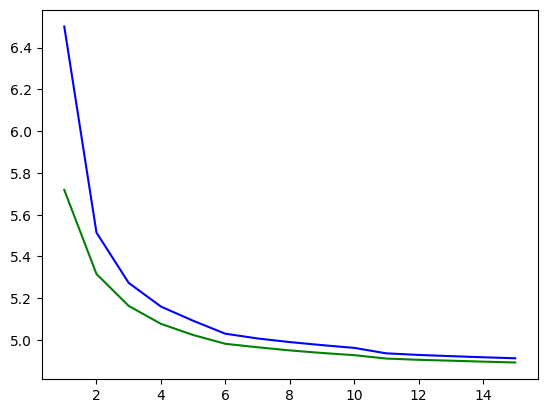

In [3]:
from src.lstm_model import LSTMAutoComplete
from src.model_train import train_one_epoch
from src.model_eval import evaluate_model

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import torch.nn as nn
import torch

import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Определяем модель:
## 2 скрытых слоя
## размерность скрытого состояния 128
model = LSTMAutoComplete(len(tokenizer.get_vocab()), hidden_size=128, num_layers=2)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, 5, 0.5)
criterion = nn.CrossEntropyLoss(ignore_index=0)
epochs = 15
last_epoch = epochs
test_phrase = "what are you talking"

# Посмотрим на валидационные метрики до обучения:
print('=== Before training ===')
evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
print('===================================\n')

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Сюда будет сохраняться лучшая модель
folder = 'checkpoints'
os.makedirs(folder, exist_ok=True)
PATH = os.path.join(folder, 'best_model.pth')

# Обучаем модель в течение 20-ти эпох
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, device, epoch, train_dataloader, optimizer, criterion, scheduler)
    val_loss = evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
    print('===================================\n')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if abs(val_loss - best_val_loss) < 1e-4:
        best_val_loss = val_loss
#       Сохраним лучшую модель
        torch.save(model.state_dict, PATH)        
        patience_counter +=1
        if patience_counter >= patience:
            print('Early stopping triggered...')
            last_epoch = epoch
            break
    else:
        patience_counter = 0

# Сохраним результаты обучения
torch.save(model.state_dict, PATH)
plt.plot(list(range(1, last_epoch+1)), train_losses, color='b')
plt.plot(list(range(1, last_epoch+1)), val_losses, color='g')
plt.show()

### Теперь на тестовых данных сравним работу LSTM модели и GPT2:

In [4]:
from src.gpt_vs_lstm_eval import evaluate_gpt_vs_lstm

evaluate_gpt_vs_lstm(model, tokenizer, test_dataloader, device=device)

Device set to use cuda
Autocompleting inputs: 100%|██████████| 515/515 [09:04<00:00,  1.06s/it]


Rouge metrics for test (GPT2):
rouge1: 0.0441
rouge2: 0.0029
rougeL: 0.0430
rougeLsum: 0.0431
Rouge metrics for test (LSTM-based):
rouge1: 0.0025
rouge2: 0.0001
rougeL: 0.0024
rougeLsum: 0.0024
=== Samples ===
Input: "i hope we can fix you"
	GPT2-autocomplete: " for the next weekend and we'll need to work on that"
	LSTM-autocomplete: ""

Input: "thanks lks like he may n race again 2 broken femurs 1 broken tibia"
	GPT2-autocomplete: " 1 broken femur 1 broken femur 1 broken femur 1 broken femur 2 broken"
	LSTM-autocomplete: ""

Input: "i left home without a cell phone but remembered my computer hey tweet me dont"
	GPT2-autocomplete: " remember. the thing i never used was my cellphone. lol. i thought"
	LSTM-autocomplete: ""

Input: "y im n in your about"
	GPT2-autocomplete: " the other guy you are at, your real life.


"
	LSTM-autocomplete: ""

Input: "this painting later vanished from my"
	GPT2-autocomplete: " collection. if you've ever wanted to go back to the painting"
	LSTM-autocomple